<a href="https://colab.research.google.com/github/siddharthc30/American-Sign-Lang-recognition/blob/master/SIgn_Language_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/signlangdata.zip','r') as zip:
  zip.extractall()


In [ ]:
! pip install keras


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split

**Sample image display**

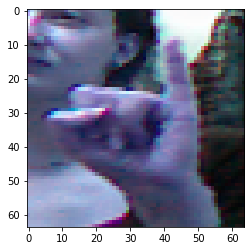

In [ ]:

img_arr=cv2.imread('/content/dataset5/C/i/color_8_0027.png',cv2.IMREAD_COLOR)
img=cv2.resize(img_arr,(64,64))
plt.imshow(img)


In [ ]:
import glob

def get_labels_images(filepath):
    data_dict = {}
    for directory in glob.glob(filepath):
        images = []
        for file in glob.glob(directory+'/color_*.png'):
            images.append(file)
        data_dict.setdefault(directory[-1], images)
        
    return data_dict

dataset=os.path.abspath('/content/dataset5/*/*')
data_dict=get_labels_images(dataset)

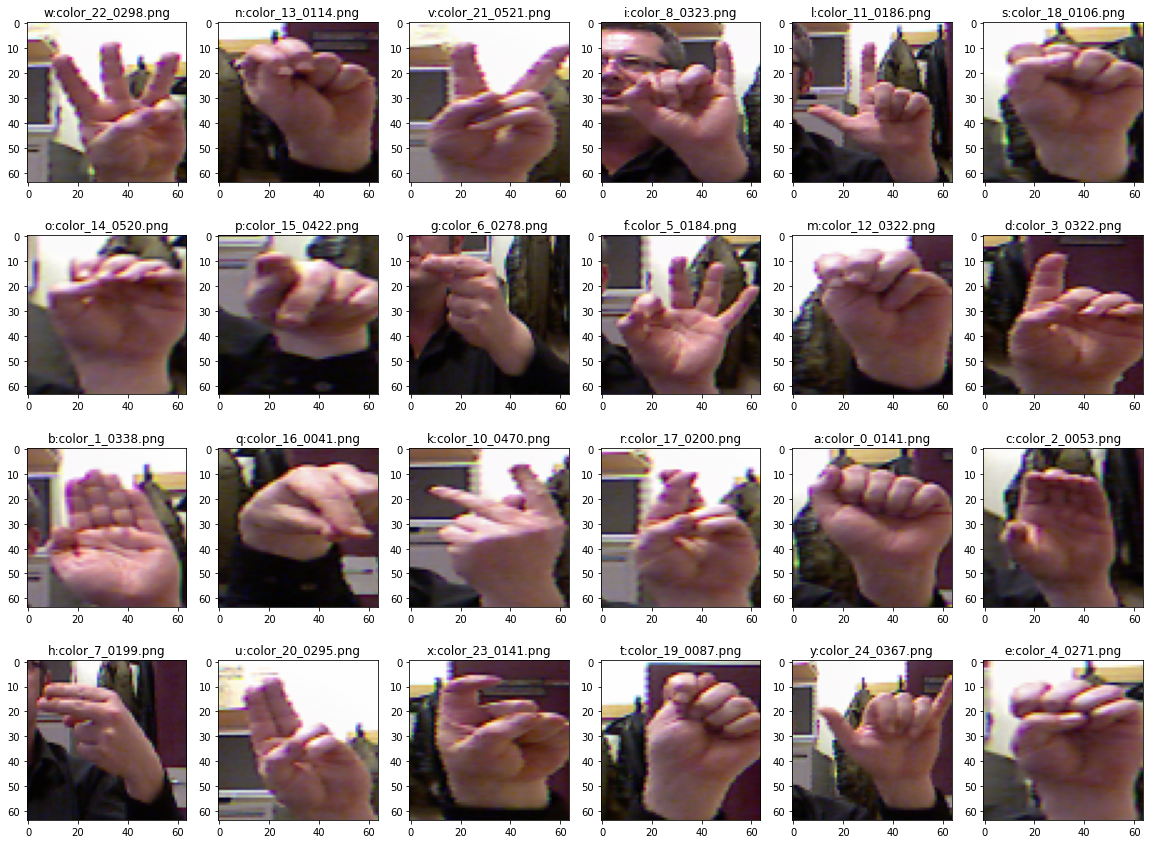

In [ ]:
plt.figure(figsize = (20,15))

for i, (k,v) in enumerate(data_dict.items()):
    img = cv2.imread(v[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    img=img/255.
    plt.subplot(4,6,i+1)
    plt.imshow(img)
    plt.title(k + ":" + os.path.basename(v[0]))
    
plt.show()

# Pre-processing Images

In [ ]:
def preprocess(dictionary):
  images=[]
  labels=[]
  for k,v in dictionary.items():
    for i in v:
      img=cv2.imread(i)
      img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img=cv2.resize(img,(64,64))
      img=img/255.
      images.append(img)
      labels.append(k)
  return (np.array(images), np.array(labels).reshape(-1,1))   

images, labels=preprocess(data_dict)

In [ ]:
from sklearn import preprocessing
label_encoding=preprocessing.LabelBinarizer()
labels=label_encoding.fit_transform(labels)

## **Using VGG-19 and transfer learning**

In [ ]:
from keras.applications.vgg19 import VGG19

img_height = 64
img_width = 64
img_channels = 3
classes = labels.shape[1]

base = VGG19(include_top = False, weights = 'imagenet', input_shape = (img_height, img_width, img_channels))
X = base.output
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(512, activation = 'relu')(X)
X = keras.layers.Dropout(0.4)(X)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Dense(512, activation = 'relu')(X)
X = keras.layers.Dropout(0.3)(X)
X = keras.layers.BatchNormalization()(X)
preds = keras.layers.Dense(classes, activation = 'softmax')(X)
model = keras.models.Model(inputs = base.input, outputs = preds)
model.compile(optimizer = keras.optimizers.RMSprop(lr = 1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])



80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 1)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, verbose = 0, restore_best_weights = True)]

history = model.fit(X_train, Y_train,
                    epochs = 25,
                    batch_size = 128,
                    validation_data = (X_val, Y_val),
                    callbacks = callbacks)

Epoch 1/25
60/60 [==============================] - 28s 465ms/step - loss: 2.8417 - accuracy: 0.2175 - val_loss: 2.4420 - val_accuracy: 0.4935
Epoch 2/25
60/60 [==============================] - 23s 380ms/step - loss: 1.5101 - accuracy: 0.5828 - val_loss: 1.3768 - val_accuracy: 0.9007
Epoch 3/25
60/60 [==============================] - 23s 379ms/step - loss: 0.7938 - accuracy: 0.8118 - val_loss: 0.5812 - val_accuracy: 0.9648
Epoch 4/25
60/60 [==============================] - 23s 377ms/step - loss: 0.4213 - accuracy: 0.9182 - val_loss: 0.2339 - val_accuracy: 0.9840
Epoch 5/25
60/60 [==============================] - 23s 378ms/step - loss: 0.2274 - accuracy: 0.9709 - val_loss: 0.1366 - val_accuracy: 0.9801
Epoch 6/25
60/60 [==============================] - 23s 379ms/step - loss: 0.1330 - accuracy: 0.9871 - val_loss: 0.0485 - val_accuracy: 0.9957
Epoch 7/25
60/60 [==============================] - 23s 379ms/step - loss: 0.0777 - accuracy: 0.9936 - val_loss: 0.0224 - val_accuracy: 0.9969

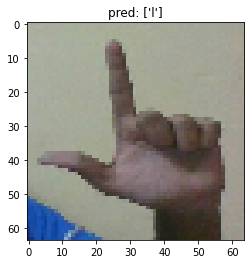

In [36]:
img = cv2.imread('/content/drive/My Drive/l.jpg')
images=[]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))
img = img / 255.
images.append(img)
imgarr=np.array(images)
preds = model.predict(imgarr)

plt.imshow(img)
plt.title('pred: {}'.format(label_encoding.classes_[np.argmax(preds, axis = -1)]))
plt.show()

In [ ]:
  model.save('Final_model.h5')

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

80/80 [==============================] - 4s 45ms/step - loss: 7.1196e-05 - accuracy: 1.0000


In [ ]:
print (loss, accuracy)

7.119639485608786e-05 1.0
